# Actividad Integradora 
#### Paola Adriana Millares Forno - A01705674

### Problemática

¡Felicidades! Eres el orgulloso propietario de 5 robots nuevos y un almacén lleno de cajas. El dueño 
anterior del almacén lo dejó en completo desorden, por lo que depende de tus robots organizar las 
cajas en algo parecido al orden y convertirlo en un negocio exitoso.  
Cada  robot  está  equipado  con  ruedas  omnidireccionales  y,  por  lo  tanto,  puede  conducir  en  las 
cuatro direcciones. Pueden recoger cajas en celdas de cuadrícula adyacentes con sus 
manipuladores, luego llevarlas a otra ubicación e incluso construir pilas de hasta cinco cajas. Todos 
los robots están equipados con la tecnología de sensores más nueva que les permite recibir datos 
de sensores de las cuatro celdas adyacentes. Por tanto, es fácil distinguir si un campo está libre, es 
una pared, contiene una pila de cajas (y cuantas cajas hay en la pila) o está ocupado por otro robot. 
Los robots también tienen sensores de presión equipados que les indican si llevan una caja en ese 
momento.  
Lamentablemente,  tu  presupuesto  resultó  insuficiente  para  adquirir  un  software  de  gestión  de 
agentes múltiples de última generación. Pero eso no debería ser un gran problema ... ¿verdad? Tu 
tarea es enseñar a sus robots cómo ordenar su almacén. La organización de los agentes depende de 
ti, siempre que todas las cajas terminen en pilas ordenadas de cinco. 

Se debera recopilar la información de cuantos movimientos tarda en ordenar las cajas y el tiempo de ejecución.
 

### Código

Declaramos las librerias que vamos a utilizar. Mesa nos ayuda a modelar los agentes. Matplotlib genera 
las gráficas.

In [10]:
# Modelado de los agentes
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Graficación de la simulación
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Medir el tiempo de ejecución
import time
import datetime

#### Definición del agente caja
Se encarga de representar a las cajas. Este agente depende totalmente del robot, solo se moverán en caso de que el robot la este cargando. Una caja puede estar ordenada o esperando a ser ordenada.

In [11]:
# Representación de la caja
class Box(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        # Dimensiones de la habitación
        self.width = width
        self.height = height
        
        # Posicion
        self.position = np.array((x, y), dtype = int)
        
        # Estado
        self.set = True
        self.ordered = False
        
        # Velocidad
        self.speed = np.array((0,0), dtype = int)
        
    def step(self):
        if self.set == False and self.ordered == False:
            self.position = self.position + self.speed

#### Robot
Permite que el robot ordene las cajas en pilas de 5, siempre iniciando en la posición (1,1). 

In [12]:
class Robot(Agent):
    def __init__(self, unique_id, model, x, y, width, height):
        super().__init__(unique_id, model)
        
        # Posicion
        self.position = np.array((x,y), dtype = int)
        
        # Posicion donde el robot va a ordenar las cajas
        self.new_box_pos = np.array((1,1), dtype = int)
        
        # Velocidad
        vel_x = np.random.randint(2)
        vel_y = np.random.randint(2)
        self.speed = np.array((vel_x, vel_y), dtype = int)
        
        # Dimensiones de la habitación
        self.width = width
        self.height = height
        
        # Movimientos realizados por el agente
        self.movimientos = 0
        
        # Posibles direcciones a las que podrá moverse
        self.directions = ["Norte", "Sur", "Este", "Oeste"]
        
        # Estado con caja o sin caja
        self.with_box = False
        
        # Caja que el robot está cargando
        self.current_box = None
        
    def step(self):
        self.check_edges()
        self.move()
        self.check_placing_pos()
        
        # Si el robot carga una caja
        if self.with_box == True:
            self.road()
            self.box_to_pos()
            self.move()
            self.current_box.speed = self.speed
            self.place_box()      
        
        # Si el robot no carga una caja
        else:
            self.move_box()
        
        self.position = self.position + self.speed
        self.movimientos += 1
        
    # Revisar que el robot no salga de los límites establecidos
    def check_edges(self):
        self.directions = ["Norte", "Sur", "Este", "Oeste"]

        if self.position[1] >= self.height - 1:
            self.directions.remove("Norte")
        elif self.position[1] <= 1:
            self.directions.remove("Sur")
        
        if self.position[0] >= self.width - 1:
            self.directions.remove("Este")
        elif self.position[0] <= 1:
            self.directions.remove("Oeste")
    
    # Permite que el robot se mueva de manera aleatoria
    def move(self):
        x = np.random.choice(self.directions)
        
        if x == 'Norte':
            self.Norte()
        elif x == 'Sur':
            self.Sur()
        elif x == 'Este':
            self.Este()
        elif x == 'Oeste':
            self.Oeste()
        
    # Posibles direcciones a las que el robot se puede mover
    def Norte(self):
        self.speed = np.array((0, 1), dtype = int)
        
    def Sur(self):
        self.speed = np.array((0, -1), dtype = int)
        
    def Este(self):
        self.speed = np.array((1, 0), dtype = int)
        
    def Oeste(self):
        self.speed = np.array((-1, 0), dtype = int)
            
    # Permite que el robot recoja una caja
    def move_box(self):
        for box in model.props.agents:
            if self.position[0] == box.position[0] and self.position[1] == box.position[1] and box.ordered == False:
                box.set = False
                box.speed = self.speed
                self.with_box = True
                self.current_box = box
    
    # El robot coloca la caja en su posición correspondiente
    def place_box(self):
        if self.current_box.position[0] == self.new_box_pos[0] and self.current_box.position[1] == self.new_box_pos[1] and self.current_box.set == False:
            model.ordered_boxes.append(self.current_box)
            self.current_box.set = True
            self.current_box.ordered = True
            self.with_box = False
            self.current_box = None
    
    # Revisa que la posición donde se dejará la caja sea valida
    def check_placing_pos(self):
        for box in model.ordered_boxes:
            if box.position[1] == self.new_box_pos[1] and box.position[0] == self.new_box_pos[0]:
                self.new_box_pos[1] += 1
            
        if self.new_box_pos[1] > 5:
            self.new_box_pos[0] += 2
            self.new_box_pos[1] = 1
    
    # El robot va a la ruta predeterminada, por la que acomodará la caja
    def road(self):
        if self.position[1] < self.height - 1:
            self.directions = ["Norte"]
            
    
    # El robot sigue la ruta predeterminada
    def box_to_pos(self):
        
        if self.position[1] == self.height - 1 and 1 <= self.position[0] < self.width - 1:
            self.directions = ["Este"]
        
        elif self.position[0] == self.width - 1 and self.new_box_pos[1] < self.position[1] <= self.height - 1:
            self.directions = ["Sur"]
        
        elif self.position[1] == self.new_box_pos[1] and self.new_box_pos[0] <= self.position[0] <= self.width - 1:
            self.directions = ["Oeste"]
                

#### Definición del modelo
Se generan los robots y las cajas de forma aleatoria en la habitación. se recopilan los datos del robot

In [13]:
# Obtiene el número de robots existentes
def get_robots(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

# Obtiene el número de cajas existentes
def get_boxes(model):
    result = []
    for box in model.props.agents:
        result.append(box.position)
    result = np.asarray(result)
    return result

# Inicializa el modelo
class Acomodar(Model):
    def __init__(self, k, N, width, height):
        self.num_boxes = k
        self.num_robots = N
        self.schedule = RandomActivation(self)
        self.props = RandomActivation(self)
        
        # Arreglo de cajas acomodadas
        self.ordered_boxes = []
        
        # Variable para saber cuando se hayan acomodado todas las cajas
        self.all_boxes_ordered = False
        
        temp = []
        i = 0
        while i in range(k):
            x = np.random.randint(1, width - 1)
            y = np.random.randint(2, height - 1)
            pos = [x,y]
            
            if pos in temp:
                continue
            
            box = Box(i, self, x, y, width, height)
            self.props.add(box)
            temp.append(pos)
            i += 1
        
        i = 0
        while i in range(self.num_robots):
            x = np.random.randint(1, width - 1)
            y = np.random.randint(1, height - 1)
            pos = [x, y]
            
            if pos in temp:
                continue
            
            r = Robot(i, self, x, y, width, height)
            self.schedule.add(r)
            temp.append(pos)
            i += 1
            
        self.datacollector = DataCollector(model_reporters = {"Robots" : get_robots, "Boxes" : get_boxes})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.props.step()
        
        if len(self.ordered_boxes) == self.num_boxes:
            self.all_boxes_ordered = True
        
    # Obtiene la cantidad de movimientos que harán los robots
    def get_movements(self):
        total = 0
        for agent in model.schedule.agents:
            total += agent.movimientos
        return total


#### Bloque principal
En el siguiente bloque se despliega:
- Tiempo total de ejecución
- Total de movimientos de todo los agentes
- Total de pasos para que todas las cajas estén ordenadas

In [14]:
WIDTH = 30
HEIGHT = 30
K = 20
N = 5

start_time = time.time()

model = Acomodar(K,N, WIDTH, HEIGHT)
mov = 0

# El ciclo se va a repetir hasta que todas las cajas estén acomodadas
while model.all_boxes_ordered == False:
    model.step()
    mov += 1

movimientos = model.get_movements()    

print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print("Total de movimientos de todos los agentes = " + str(movimientos))
print("Total de pasos para que se acomodaran todas las cajas = " + str(mov))

Tiempo de ejecución: 0:00:02.798698
Total de movimientos de todos los agentes = 41685
Total de pasos para que se acomodaran todas las cajas = 8337


#### Animación

In [15]:
WIDTH = 10
HEIGHT = 10
K = 20
N = 5
MAX_ITERATIONS = 500

model = Acomodar(K, N, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()

In [16]:
all_positions = model.datacollector.get_model_vars_dataframe()

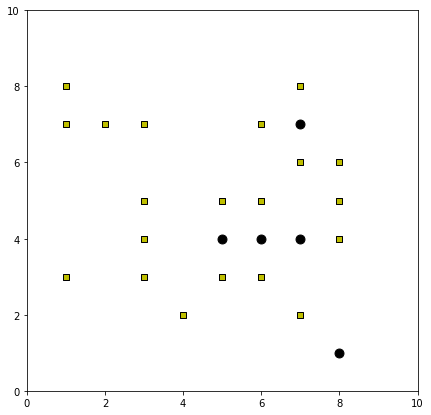

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=80, cmap="jet", edgecolor="k",  marker="o", color = "k")

boxes = ax.scatter(all_positions.iloc[0][1][:,0], all_positions.iloc[0][1][:,1], 
                  s=40, cmap="jet", edgecolor="k", marker="s", color="y")


ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    boxes.set_offsets(all_positions.iloc[frame_number][1])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

In [18]:
anim

#### Conclusión
En algunos casos la ejecución tarda más de un segundo, lo cual puede reducirse aplicando estrategias de análisis de datos e inteligencia artificial. Actualmente esta animación no se encuentra optimizada a su máxima capacidad, ya que se visitan las celdas aunque un robot ya haya pasado por ellas, y siempre se seguira la ruta predefinida, no la mas corta. 